In [31]:
#import libraries
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.metrics import MeanAbsoluteError
warnings.filterwarnings("ignore")

In [2]:
#set working directory
working_directory = "C:/Users/ADMIN/Documents/Agriculture Project"
os.chdir = working_directory

In [3]:
#load dataset
df = pd.read_csv("C:/Users/ADMIN/Documents/Agriculture Project/city_temperature.csv")
df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


In [4]:
#Checking if all the cities has the data for a full range
df['City'].value_counts()

City
Springfield      18530
Columbus         18530
Portland         18530
Washington DC    18530
Washington       18530
                 ...  
Frankfurt         4136
Flagstaff         3574
Pristina          3427
Yerevan           3226
Bonn              3133
Name: count, Length: 321, dtype: int64

In [5]:
#time series for a random city
chennai = df[df["City"] == "Chennai (Madras)"]
chennai.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
331055,Asia,India,NaN,Chennai (Madras),1,1,1995,72.4
331056,Asia,India,NaN,Chennai (Madras),1,2,1995,73.5
331057,Asia,India,NaN,Chennai (Madras),1,3,1995,72.6
331058,Asia,India,NaN,Chennai (Madras),1,4,1995,75.2
331059,Asia,India,NaN,Chennai (Madras),1,5,1995,74.8


In [6]:
#do any missing values for the years
chennai["Year"].value_counts()

Year
2008    366
2000    366
2016    366
2015    366
2004    366
2012    366
1996    366
2010    365
2019    365
2018    365
2017    365
2014    365
2013    365
2011    365
1995    365
2009    365
2007    365
2006    365
2005    365
2003    365
2002    365
2001    365
1999    365
1998    365
1997    365
2020    134
Name: count, dtype: int64

In [7]:
#fill
chennai["AvgTemperature"] = np.where(chennai["AvgTemperature"] == -99, np.nan, chennai["AvgTemperature"])
chennai.isnull().sum()

Region               0
Country              0
State             9266
City                 0
Month                0
Day                  0
Year                 0
AvgTemperature      29
dtype: int64

In [8]:
#check for null after filling
chennai["AvgTemperature"] = chennai["AvgTemperature"].ffill()
chennai.isnull().sum()

Region               0
Country              0
State             9266
City                 0
Month                0
Day                  0
Year                 0
AvgTemperature       0
dtype: int64

In [9]:
#create date column
chennai.dtypes
chennai["Time_steps"] = pd.to_datetime((chennai.Year*10000 + chennai.Month*100 + chennai.Day).apply(str),format='%Y%m%d')
chennai.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature,Time_steps
331055,Asia,India,NaN,Chennai (Madras),1,1,1995,72.4,1995-01-01
331056,Asia,India,NaN,Chennai (Madras),1,2,1995,73.5,1995-01-02
331057,Asia,India,NaN,Chennai (Madras),1,3,1995,72.6,1995-01-03
331058,Asia,India,NaN,Chennai (Madras),1,4,1995,75.2,1995-01-04
331059,Asia,India,NaN,Chennai (Madras),1,5,1995,74.8,1995-01-05


In [10]:
def plot_series(time, series, format="-", start=0, end=None):
    """to plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Year")
    plt.ylabel("Temprature")
    plt.grid(True)

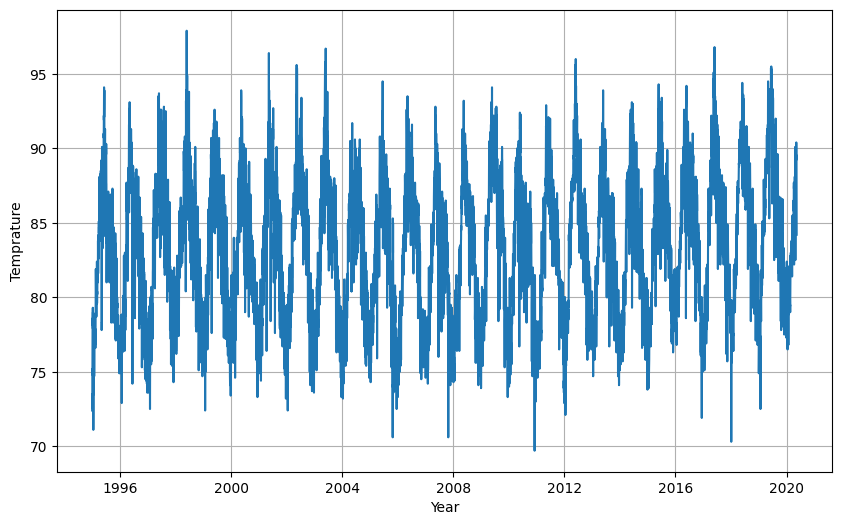

In [11]:
#time series for the entire time
time_step = chennai["Time_steps"].tolist()
temprature = chennai["AvgTemperature"].tolist()

series = np.array(temprature)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

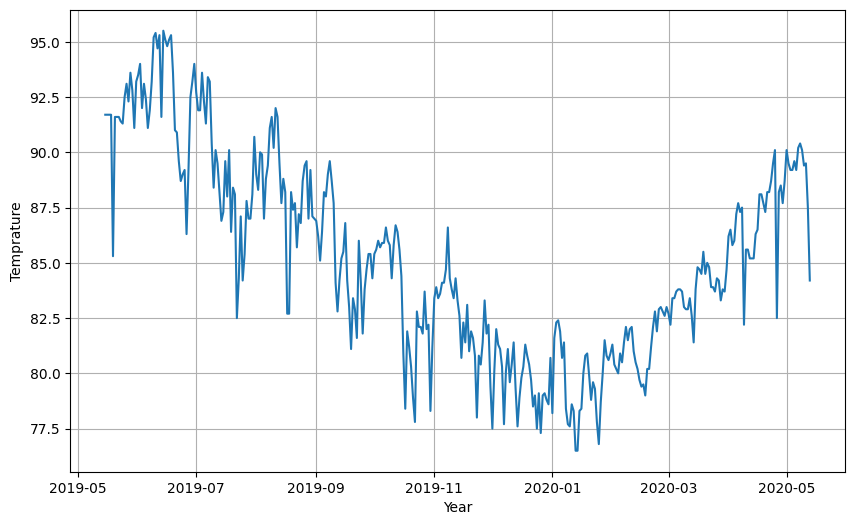

In [12]:
#the recent year
plt.figure(figsize=(10, 6))
plot_series(time[-365:], series[-365:])

In [13]:
#split data
split_time = 8000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [14]:
#convert numpy array to tensor
series1 = tf.expand_dims(series, axis=-1)
ds = tf.data.Dataset.from_tensor_slices(series1[:20])
for val in ds:
    print(val.numpy())

[72.4]
[73.5]
[72.6]
[75.2]
[74.8]
[76.4]
[78.4]
[78.6]
[78.1]
[79.3]
[77.9]
[79.]
[73.4]
[76.7]
[73.7]
[77.]
[71.1]
[72.6]
[76.1]
[75.7]


In [15]:
#group 5 observation into 1
dataset = ds.window(5, shift=1)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

[72.4] [73.5] [72.6] [75.2] [74.8] 
[73.5] [72.6] [75.2] [74.8] [76.4] 
[72.6] [75.2] [74.8] [76.4] [78.4] 
[75.2] [74.8] [76.4] [78.4] [78.6] 
[74.8] [76.4] [78.4] [78.6] [78.1] 
[76.4] [78.4] [78.6] [78.1] [79.3] 
[78.4] [78.6] [78.1] [79.3] [77.9] 
[78.6] [78.1] [79.3] [77.9] [79.] 
[78.1] [79.3] [77.9] [79.] [73.4] 
[79.3] [77.9] [79.] [73.4] [76.7] 
[77.9] [79.] [73.4] [76.7] [73.7] 
[79.] [73.4] [76.7] [73.7] [77.] 
[73.4] [76.7] [73.7] [77.] [71.1] 
[76.7] [73.7] [77.] [71.1] [72.6] 
[73.7] [77.] [71.1] [72.6] [76.1] 
[77.] [71.1] [72.6] [76.1] [75.7] 
[71.1] [72.6] [76.1] [75.7] 
[72.6] [76.1] [75.7] 
[76.1] [75.7] 
[75.7] 


In [16]:
#drop variables with no grouping dataset = ds.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

[72.4] [73.5] [72.6] [75.2] [74.8] 
[73.5] [72.6] [75.2] [74.8] [76.4] 
[72.6] [75.2] [74.8] [76.4] [78.4] 
[75.2] [74.8] [76.4] [78.4] [78.6] 
[74.8] [76.4] [78.4] [78.6] [78.1] 
[76.4] [78.4] [78.6] [78.1] [79.3] 
[78.4] [78.6] [78.1] [79.3] [77.9] 
[78.6] [78.1] [79.3] [77.9] [79.] 
[78.1] [79.3] [77.9] [79.] [73.4] 
[79.3] [77.9] [79.] [73.4] [76.7] 
[77.9] [79.] [73.4] [76.7] [73.7] 
[79.] [73.4] [76.7] [73.7] [77.] 
[73.4] [76.7] [73.7] [77.] [71.1] 
[76.7] [73.7] [77.] [71.1] [72.6] 
[73.7] [77.] [71.1] [72.6] [76.1] 
[77.] [71.1] [72.6] [76.1] [75.7] 
[71.1] [72.6] [76.1] [75.7] 
[72.6] [76.1] [75.7] 
[76.1] [75.7] 
[75.7] 


In [17]:
#group 5 observation into 1 tensor varaible
dataset = ds.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
    print(window.numpy())

[[72.4]
 [73.5]
 [72.6]
 [75.2]
 [74.8]]
[[73.5]
 [72.6]
 [75.2]
 [74.8]
 [76.4]]
[[72.6]
 [75.2]
 [74.8]
 [76.4]
 [78.4]]
[[75.2]
 [74.8]
 [76.4]
 [78.4]
 [78.6]]
[[74.8]
 [76.4]
 [78.4]
 [78.6]
 [78.1]]
[[76.4]
 [78.4]
 [78.6]
 [78.1]
 [79.3]]
[[78.4]
 [78.6]
 [78.1]
 [79.3]
 [77.9]]
[[78.6]
 [78.1]
 [79.3]
 [77.9]
 [79. ]]
[[78.1]
 [79.3]
 [77.9]
 [79. ]
 [73.4]]
[[79.3]
 [77.9]
 [79. ]
 [73.4]
 [76.7]]
[[77.9]
 [79. ]
 [73.4]
 [76.7]
 [73.7]]
[[79. ]
 [73.4]
 [76.7]
 [73.7]
 [77. ]]
[[73.4]
 [76.7]
 [73.7]
 [77. ]
 [71.1]]
[[76.7]
 [73.7]
 [77. ]
 [71.1]
 [72.6]]
[[73.7]
 [77. ]
 [71.1]
 [72.6]
 [76.1]]
[[77. ]
 [71.1]
 [72.6]
 [76.1]
 [75.7]]


In [18]:
#split variables into X an y
dataset = ds.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
    print(x.numpy(), y.numpy())

[[72.4]
 [73.5]
 [72.6]
 [75.2]] [[74.8]]
[[73.5]
 [72.6]
 [75.2]
 [74.8]] [[76.4]]
[[72.6]
 [75.2]
 [74.8]
 [76.4]] [[78.4]]
[[75.2]
 [74.8]
 [76.4]
 [78.4]] [[78.6]]
[[74.8]
 [76.4]
 [78.4]
 [78.6]] [[78.1]]
[[76.4]
 [78.4]
 [78.6]
 [78.1]] [[79.3]]
[[78.4]
 [78.6]
 [78.1]
 [79.3]] [[77.9]]
[[78.6]
 [78.1]
 [79.3]
 [77.9]] [[79.]]
[[78.1]
 [79.3]
 [77.9]
 [79. ]] [[73.4]]
[[79.3]
 [77.9]
 [79. ]
 [73.4]] [[76.7]]
[[77.9]
 [79. ]
 [73.4]
 [76.7]] [[73.7]]
[[79. ]
 [73.4]
 [76.7]
 [73.7]] [[77.]]
[[73.4]
 [76.7]
 [73.7]
 [77. ]] [[71.1]]
[[76.7]
 [73.7]
 [77. ]
 [71.1]] [[72.6]]
[[73.7]
 [77. ]
 [71.1]
 [72.6]] [[76.1]]
[[77. ]
 [71.1]
 [72.6]
 [76.1]] [[75.7]]


In [19]:
#shuffle
dataset = ds.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x,y in dataset:
    print(x.numpy(), y.numpy())

[[73.5]
 [72.6]
 [75.2]
 [74.8]] [[76.4]]
[[79.3]
 [77.9]
 [79. ]
 [73.4]] [[76.7]]
[[79. ]
 [73.4]
 [76.7]
 [73.7]] [[77.]]
[[73.4]
 [76.7]
 [73.7]
 [77. ]] [[71.1]]
[[74.8]
 [76.4]
 [78.4]
 [78.6]] [[78.1]]
[[72.4]
 [73.5]
 [72.6]
 [75.2]] [[74.8]]
[[75.2]
 [74.8]
 [76.4]
 [78.4]] [[78.6]]
[[78.4]
 [78.6]
 [78.1]
 [79.3]] [[77.9]]
[[76.4]
 [78.4]
 [78.6]
 [78.1]] [[79.3]]
[[73.7]
 [77. ]
 [71.1]
 [72.6]] [[76.1]]
[[77.9]
 [79. ]
 [73.4]
 [76.7]] [[73.7]]
[[76.7]
 [73.7]
 [77. ]
 [71.1]] [[72.6]]
[[78.6]
 [78.1]
 [79.3]
 [77.9]] [[79.]]
[[78.1]
 [79.3]
 [77.9]
 [79. ]] [[73.4]]
[[77. ]
 [71.1]
 [72.6]
 [76.1]] [[75.7]]
[[72.6]
 [75.2]
 [74.8]
 [76.4]] [[78.4]]


In [20]:
#group into mini batches
dataset = ds.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print("*"*25)

x =  [[[78.6]
  [78.1]
  [79.3]
  [77.9]]

 [[72.6]
  [75.2]
  [74.8]
  [76.4]]]
y =  [[[79. ]]

 [[78.4]]]
*************************
x =  [[[73.5]
  [72.6]
  [75.2]
  [74.8]]

 [[77.9]
  [79. ]
  [73.4]
  [76.7]]]
y =  [[[76.4]]

 [[73.7]]]
*************************
x =  [[[79. ]
  [73.4]
  [76.7]
  [73.7]]

 [[74.8]
  [76.4]
  [78.4]
  [78.6]]]
y =  [[[77. ]]

 [[78.1]]]
*************************
x =  [[[77. ]
  [71.1]
  [72.6]
  [76.1]]

 [[76.7]
  [73.7]
  [77. ]
  [71.1]]]
y =  [[[75.7]]

 [[72.6]]]
*************************
x =  [[[72.4]
  [73.5]
  [72.6]
  [75.2]]

 [[78.4]
  [78.6]
  [78.1]
  [79.3]]]
y =  [[[74.8]]

 [[77.9]]]
*************************
x =  [[[78.1]
  [79.3]
  [77.9]
  [79. ]]

 [[73.4]
  [76.7]
  [73.7]
  [77. ]]]
y =  [[[73.4]]

 [[71.1]]]
*************************
x =  [[[76.4]
  [78.4]
  [78.6]
  [78.1]]

 [[75.2]
  [74.8]
  [76.4]
  [78.4]]]
y =  [[[79.3]]

 [[78.6]]]
*************************
x =  [[[73.7]
  [77. ]
  [71.1]
  [72.6]]

 [[79.3]
  [77.9]
 

In [21]:
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [22]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    To create a window dataset given a numpy as input

    Returns: A prefetched tensorflow dataset
    """
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [23]:
 #build the model
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)


Epoch 1/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 193ms/step - loss: 175.6129 - mae: 176.1109
Epoch 2/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - loss: 11.2348 - mae: 11.7125
Epoch 3/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 9.4143 - mae: 9.8898
Epoch 4/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - loss: 8.4616 - mae: 8.9359
Epoch 5/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 7.7296 - mae: 8.2023
Epoch 6/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 7.1003 - mae: 7.5718
Epoch 7/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - loss: 6.4946 - mae: 6.9643
Epoch 8/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 5.9804 - mae: 6.4484
Epoch 9/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - loss: 5.5579 - mae: 6.0247
Epoch 10/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - loss: 5.1549 - mae: 5.6209
Epoch 11/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - loss: 4.8090 - mae: 5.2737
Epoch 12/500
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - loss: 4.4724 - mae: 4.

In [25]:
def model_forecast(model, series, window_size):
    """
    Given a model object and a series for it to predict, this function will return the prediction
    """
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [26]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step


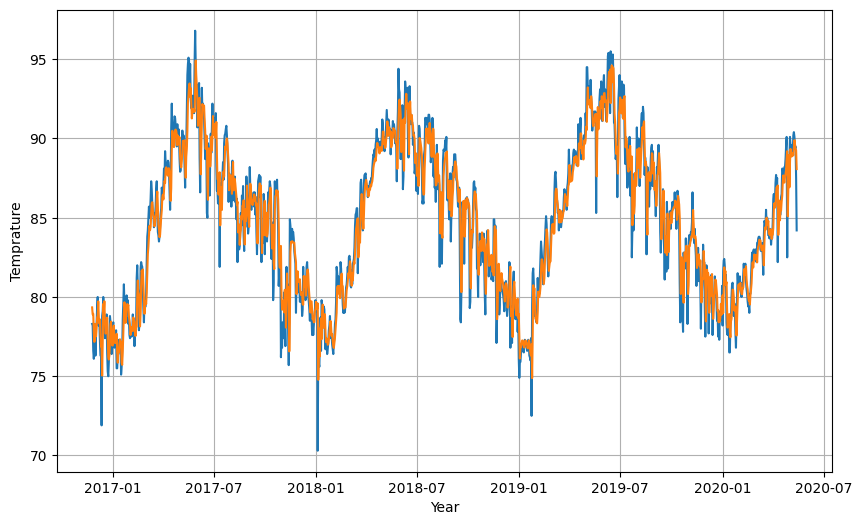

In [27]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

The graph shows the comparison between the actual temperature data (blue line) and the forecasted values (orange line) generated by the model. Overall, the model seems to capture the general trend of the temperature data

In [39]:
# Function to plot series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [44]:
# Forecasting
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[:, -1, 0]  # Take the last element from the second dimension

# Ensure that rnn_forecast has the same length as time_valid[window_size:]
rnn_forecast = rnn_forecast[:len(time_valid[window_size:])]

288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step


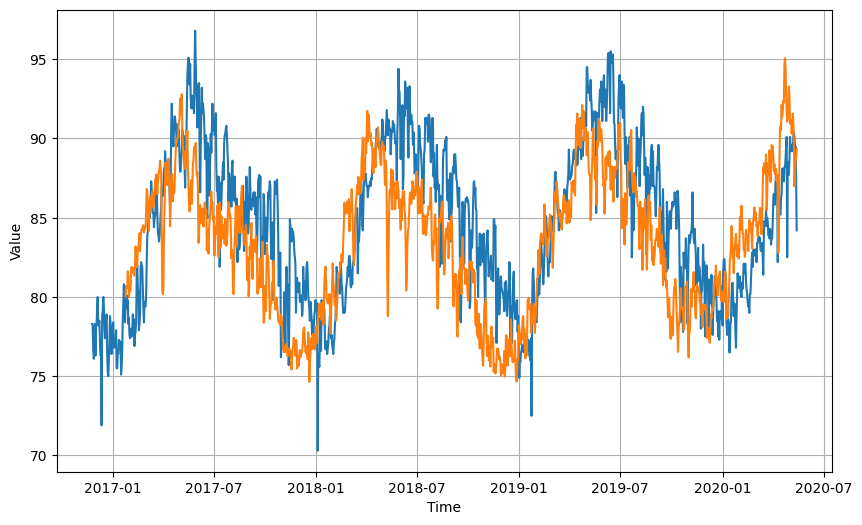

In [45]:

# Plotting
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid[window_size:], rnn_forecast)
plt.show()

The validation plot compares the actual data (blue line) with the forecasted values (orange line) generated by the model. The model appears to closely track the actual data, indicating that it has learned the underlying patterns well

In [46]:

# Print the final MAE
final_mae = history.history['mae'][-1]
print(f"Final MAE: {final_mae}")


Final MAE: 1.3705604076385498


This suggests that the model has achieved a reasonably low error rate, indicating a good fit to the training data.

<Figure size 640x480 with 0 Axes>

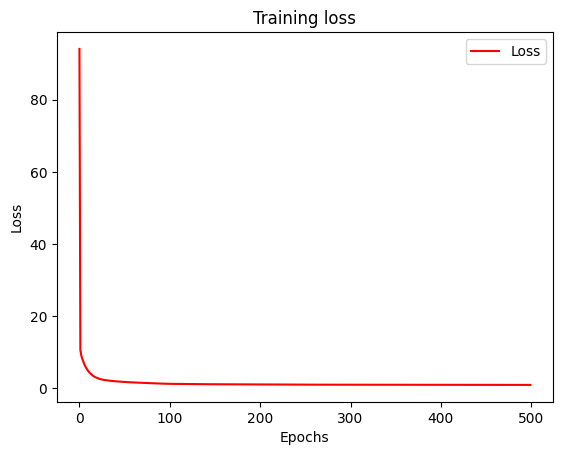

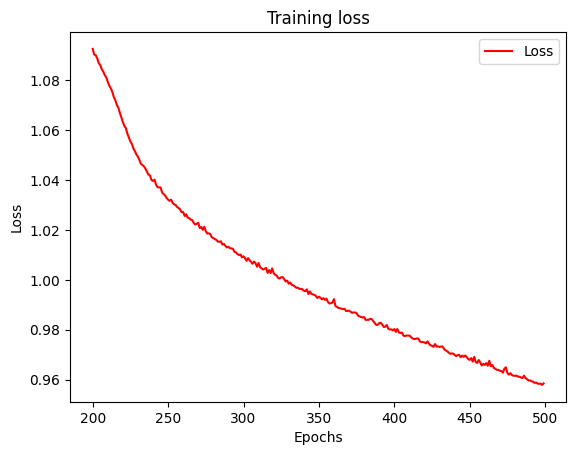

<Figure size 640x480 with 0 Axes>

In [30]:
#loss
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

The first plot shows the training loss for all epochs.
The second plot zooms in on the training loss from epoch 200 to the final epoch (500).
These plots can help visualize how the training loss decreases over time as the model learns from the training data. Lower values indicate that the model is fitting the training data better.